In [1]:
using PureSeq

In [14]:
ids = ["ENCFF000NYK", "ENCFF000NYY", "ENCFF000NZA", "ENCFF000NYN"]
readers = map(x->ContextMap(BinnedReader("/scratch2/slund1/pure-seq/binned_data/$x.bam.fbin100"), 4, 4), ids)
data = nothing
for block in denseblocks(readers, 32000000)
    println(size(block))
    data = block
    break
end
map(close, readers)

U,s,V = svd(data)
s2 = zeros(length(s))
s2[1] = s[1]
newData = U * diagm(s2)*V'

writedlm("/scratch2/slund1/pure-seq/forwardReads_SVD_REST.pred", newData[:,1])

(32000000,4)


In [5]:
U,s,V = svd(data)

(
3200000x4 Array{Float64,2}:
 -5.5336e-14    1.11538e-13  -2.95284e-13  -1.20726e-13
 -1.73945e-13   2.23654e-14   3.86862e-13  -5.22993e-13
  5.87126e-14  -3.86967e-14  -5.38283e-16   6.20147e-15
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
  ⋮                                                    
 -1.83302e-5   -7.53589e-5    0.00031917    0.000893943
  0.0           0.0           0.0           0.0        
  0.0           0.0           0.0           0.0        
 -3.66605e-5   -0.

<h3>Load Metadata</h3>

In [46]:
# find out the target label and other metadata of all the experiments
root = "/scratch2/slund1/ENCSR000BQS_notebook"
metadataDir = "/homes/gws/slund1/projects/genomic-structure-learning/data/metadata"
controlIds = ASCIIString[]
for file in readdir(metadataDir)
    obj = open(f->JSON.parse(readall(f)), "$metadataDir/$file")
    if ismatch(r"[Cc]ontrol", obj["target"]["label"])
        for file in obj["files"]
            asc = file["accession"]            
            if file["file_format"] == "fastq" && isfile("$root/$asc.bam.rbin100") && isfile("$root/$asc.bam.fbin100")
                push!(controlIds, asc)
            end
        end
    end
end

In [51]:
function train_against_controls(targetFile, controlFiles; blockSize=10000, blockLimit=Inf)
    
    # build our control feature maps
    readers = [BinnedReader(controlFiles[i]) for i in 1:length(controlFiles)]
    
    # our target reader
    target = BinnedReader(targetFile)

    # we want to compute XtX and Xty block by block
    P = length(controlFiles) + 1
    XtX = zeros(P,P)
    Xty = zeros(P)
    printInterval = max(1,int(min(blockLimit, int(sum(ReferenceContigs_hg38.sizes)/blockSize))/10))
    
    # use denseblocks to iterate over blocks of the target and control data
    count = 0
    sse = 0.0
    sseTest = Float64[]
    for (target,control) in zip(denseblocks([target], blockSize), denseblocks(readers, blockSize, constantColumn=true, loop=true))
        count += 1
        if count > blockLimit break end
        
        # compute the betas for this data up to this point and get our test error on the next block
        betas = inv(XtX + 0.00001*eye(P))*Xty
        sse = sum((target - control*betas).^2)
        push!(sseTest, sse)

        # update our estimates
        XtX .+= control'control
        Xty .+= control'target
        
        if count % printInterval == 0
            println("Processed $(count*blockSize) positions...")
        end
    end
    betas = inv(XtX + 0.00001*eye(P))*Xty
    betas,sseTest
end

train_against_controls (generic function with 1 method)

In [59]:
writedlm("sseTest400r.txt", sseTest400r)

In [55]:
targetId = "ENCFF000NYK"
@time betas400f,sseTest400f = train_against_controls(
    "$root/$targetId.bam.fbin100",
    ["$root/$id.bam.fbin100" for id in controlIds[1:400]],
    blockLimit=40000
)
@time betas400r,sseTest400r = train_against_controls(
    "$root/$targetId.bam.rbin100",
    ["$root/$id.bam.rbin100" for id in controlIds[1:400]],
    blockLimit=40000
)

elapsed time: 2858.488710358 seconds (409943008176 bytes allocated, 26.10% gc time)
elapsed time: 2674.01163673 seconds (410064917152 bytes allocated, 26.44% gc time)


(
401x1 Array{Float64,2}:
  0.00296584 
  0.000377463
  0.00610787 
  0.00415995 
  0.0107375  
  0.00712907 
  0.00121742 
  0.00363042 
 -0.0130493  
  0.00595667 
  0.00551792 
  0.00071601 
 -0.0179669  
  ⋮          
 -0.00144549 
 -0.00335931 
 -0.00145714 
  0.00349498 
 -0.00396536 
  0.000478766
 -0.000994336
 -0.00158663 
 -0.00270809 
  0.00437823 
  0.00582682 
 -0.0085943  ,

[333552.0,26737.7,11659.9,31782.2,6322.28,19900.7,1.17646e6,126205.0,6638.21,7634.59  …  0.769718,0.767911,0.76611,0.764316,0.762528,0.760746,0.75897,3818.59,377.473,0.740334])

In [41]:
targetId = "ENCFF000NYK"
@time betas0,sseTest0 = train_against_controls(
    "$root/$targetId.bam.fbin100",
    Any[],
    blockLimit=4000
)

Processed 4000000 positions...
Processed 8000000 positions...
Processed 12000000 positions...
Processed 16000000 positions...
Processed 20000000 positions...
Processed 24000000 positions...
Processed 28000000 positions...
Processed 32000000 positions...
elapsed time: 6.539555735 seconds (1389078580 bytes allocated, 36.12% gc time)


(
1x1 Array{Float64,2}:
 0.225379,

[337046.0,28640.6,13730.0,29069.8,6287.76,28159.6,915219.0,107766.0,3975.21,6416.74  …  510.924,510.605,510.286,509.967,509.649,509.331,509.014,3848.63,5057.77,508.271])

In [43]:

targetId = "ENCFF000NYK"
controlIds7 = [
    "ENCFF000ODO", # designated control
    "ENCFF000ODV", # another GM12878 control (rep1)
    "ENCFF000ODZ", # another GM12878 control (rep2)
    "ENCFF000OEB", # another GM12878 control (rep3)
    "ENCFF000NGK",
    "ENCFF000NGM",
    "ENCFF000NGN"
]
@time betas7,sseTest7 = train_against_controls(
    "$root/$targetId.bam.fbin100",
    ["$root/$id.bam.fbin100" for id in controlIds7],
    blockLimit=4000
)

Processed 4000000 positions...
Processed 8000000 positions...
Processed 12000000 positions...
Processed 16000000 positions...
Processed 20000000 positions...
Processed 24000000 positions...
Processed 28000000 positions...
Processed 32000000 positions...
elapsed time: 67.046915525 seconds (9783560116 bytes allocated, 26.21% gc time)


(
8x1 Array{Float64,2}:
  0.0105314
  0.0547151
 -0.0826741
  0.0853327
  0.040312 
  0.0801507
  0.0218867
  0.109708 ,

[337046.0,28536.4,13246.2,28940.6,6214.95,28157.8,914749.0,107851.0,4192.0,6339.81  …  120.47,120.382,120.294,120.206,120.118,120.03,119.943,24186.6,1859.09,120.447])

In [18]:
@everywhere root = "/scratch2/slund1/ENCSR000BQS_notebook"
targetId = "ENCFF000NYK"
controlIds35 = [
    "ENCFF000ODO", # designated control
    "ENCFF000ODV", # another GM12878 control (rep1)
    "ENCFF000ODZ", # another GM12878 control (rep2)
    "ENCFF000OEB", # another GM12878 control (rep3)
    "ENCFF000NGK",
    "ENCFF000NGM",
    "ENCFF000NGN",
    "ENCFF000QET",
    "ENCFF000QEU",
    "ENCFF000QFL",
    "ENCFF000QFS",
    "ENCFF000RCB",
    "ENCFF000RCC",
    "ENCFF000RCF",
    "ENCFF000RPT",
    "ENCFF000SAZ",
    "ENCFF000VPI",
    "ENCFF000VPK",
    "ENCFF000WIQ",
    "ENCFF000WIX",
    "ENCFF000WPT",
    "ENCFF000WPV",
    "ENCFF000XOO",
    "ENCFF000XRH",
    "ENCFF000XRI",
    "ENCFF000XTE",
    "ENCFF000YPF",
    "ENCFF000YPM",
    "ENCFF000YRC",
    "ENCFF000YRN",
    "ENCFF000ZSI",
    "ENCFF000ZVJ",
    "ENCFF000ZVV",
    "ENCFF001HAV",
    "ENCFF001HGV"
]
@time betas35,sseTest35 = train_against_controls(
    "$root/$targetId.bam.fbin100",
    ["$root/$id.bam.fbin100" for id in controlIds35],
    blockLimit=40
)

Processed 400000 positions...
Processed 800000 positions...
Processed 1200000 positions...
Processed 1600000 positions...
Processed 2000000 positions...
Processed 2400000 positions...
Processed 2800000 positions...
Processed 3200000 positions...
Processed 3600000 positions...
Processed 4000000 positions...
elapsed time: 32.638478956 seconds (4704966780 bytes allocated, 23.32% gc time)


(
36x1 Array{Float64,2}:
  0.0340567 
  0.0167494 
 -0.0172548 
  0.0175444 
  0.00381412
  0.0224456 
  0.00605606
 -0.00267384
 -0.0202711 
  0.0717477 
  0.0343839 
  0.0164507 
  0.0264361 
  ⋮         
  0.112387  
  0.024537  
 -0.0230894 
 -0.0258112 
  0.00435976
  0.0215982 
  0.031963  
  0.0326149 
  0.0266101 
  0.0186912 
  0.0541174 
  0.0106063 ,

[1.48591e6,529593.0,2.40391e6,1.47758e6,509836.0,151584.0,56696.0,98352.0,23341.3,204325.0  …  49983.4,58538.3,176923.0,309854.0,937660.0,1.06627e6,91084.1,1.18222e6,117556.0,65188.4])

In [31]:


for i in 1:20
    println("$(round(sqrt(sseTest0[i]/100000), 3))\t$(round(sqrt(sseTest7[i]/100000), 3))\t$(round(sqrt(sseTest35[i]/100000), 3))\t$(round(sqrt(sseTest200[i]/100000), 3))")
end

3.855	3.855	3.855	3.855
2.304	2.303	2.301	2.31
4.909	4.907	4.903	4.901
3.851	3.848	3.844	3.838
2.264	2.26	2.258	2.255
1.239	1.235	1.231	1.233
0.771	0.765	0.753	0.753
1.006	1.001	0.992	0.989
0.505	0.498	0.483	0.482
1.438	1.436	1.429	1.426
1.275	1.271	1.265	1.261
2.104	2.101	2.098	2.095
1.123	1.007	0.765	0.423
0.268	0.134	0.039	0.007
2.737	1.628	1.179	1.187
3.18	3.18	3.173	3.169
1.25	1.254	1.243	1.239
0.975	0.984	0.97	0.965
0.811	0.821	0.803	7.876
0.448	0.467	0.436	0.43


In [13]:
using Gadfly

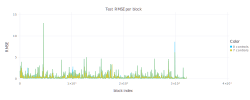

In [44]:
plotLimit = length(sseTest7)
set_default_plot_size(25cm,10cm)
plot(
    x=[1:plotLimit, 1:plotLimit],
    y=[
        [sqrt(v / 100000) for v in sseTest0[1:plotLimit]],
        [sqrt(v / 100000) for v in sseTest7[1:plotLimit]]
        #[sqrt(v / 100000) for v in sseTest35[1:plotLimit]],
        #[sqrt(v / 100000) for v in sseTest200[1:plotLimit]]
    ],
    color=[
        ["0 controls" for i in 1:plotLimit],
        ["7 controls" for i in 1:plotLimit]#,
        #["35 controls" for i in 1:plotLimit],
        #["200 controls" for i in 1:plotLimit]
    ],
    Geom.line,
    Guide.title("Test RMSE per block"),
    Guide.xlabel("block index"),
    Guide.ylabel("RMSE")
)

In [13]:
sum(sseTest0), sum(sseTest7), sum(sseTest35)

(1.1952674530288577e8,1.1404265551297078e8,1.0923843537265953e8)

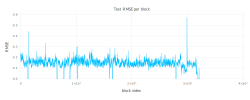

In [39]:
plot(
    x=1:length(sseTest0),
    y=[sqrt(v / 100000) for v in sseTest0],
    Geom.line,
    Guide.title("Test RMSE per block"),
    Guide.xlabel("block index"),
    Guide.ylabel("RMSE")
)

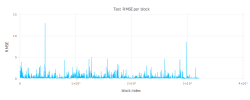

In [42]:
plot(
    x=1:length(sseTest0),
    y=[sqrt(v / 100000) for v in sseTest0],
    Geom.line,
    Guide.title("Test RMSE per block"),
    Guide.xlabel("block index"),
    Guide.ylabel("RMSE")
)

In [55]:
@everywhere function convert_to_binned(bamFile, binSize, useReverseReads)
    bm = BinningMap(BamReader(bamFile, useReverseReads, ReferenceContigs_hg38), binSize)
    out = open(bamFile*"."*(useReverseReads ? "r" : "f")*"bin$binSize", "w")
    while !eof(bm)
        write(out, uint32(bm.position))
        write(out, uint32(bm.value))
        advance!(bm)
    end
    close(out)
end

In [56]:
controlIds35 = [
    "ENCFF000ODO", # designated control
    "ENCFF000ODV", # another GM12878 control (rep1)
    "ENCFF000ODZ", # another GM12878 control (rep2)
    "ENCFF000OEB", # another GM12878 control (rep3)
    "ENCFF000NGK",
    "ENCFF000NGM",
    "ENCFF000NGN",
    "ENCFF000QET",
    "ENCFF000QEU",
    "ENCFF000QFL",
    "ENCFF000QFS",
    "ENCFF000RCB",
    "ENCFF000RCC",
    "ENCFF000RCF",
    "ENCFF000RPT",
    "ENCFF000SAZ",
    "ENCFF000VPI",
    "ENCFF000VPK",
    "ENCFF000WIQ",
    "ENCFF000WIX",
    "ENCFF000WPT",
    "ENCFF000WPV",
    "ENCFF000XOO",
    "ENCFF000XRH",
    "ENCFF000XRI",
    "ENCFF000XTE",
    "ENCFF000YPF",
    "ENCFF000YPM",
    "ENCFF000YRC",
    "ENCFF000YRN",
    "ENCFF000ZSI",
    "ENCFF000ZVJ",
    "ENCFF000ZVV",
    "ENCFF001HAV",
    "ENCFF001HGV"
]

@parallel for id in idsToMap
    convert_to_binned("$root/$id.bam", 100, false)
    convert_to_binned("$root/$id.bam", 100, true)
end

In [24]:
@time convert_to_binned("$root/$targetId.bam", 100, false)

elapsed time: 33.6072523 seconds (1634475420 bytes allocated, 4.29% gc time)


In [49]:
function read_binned(fileName, binSize)
    f = open(fileName)
    pair = zeros(Uint32, 2)
    count = 0
    while !eof(f)
        read!(f, pair)
        count += 1
    end
    close(f)
end

read_binned (generic function with 1 method)

In [50]:
@time read_binned("$root/ENCFF000NYK.bam.fbin100", 100)

5475880
elapsed time: 0.203038833 seconds (594768 bytes allocated)


In [57]:
type BinnedReader
    fileStream
    pair::Array{Uint32}
end

function BinnedReader(fileName::ASCIIString)
    f = open(fileName)
    br = BinnedReader(f, zeros(Uint32, 2))
    advance!(br)
    br
end
close(br::BinnedReader) = close(br.reader)
value(br::BinnedReader) = br.pair[2]
position(br::BinnedReader) = br.pair[1]
eof(br::BinnedReader) = br.pair[1] == 0

function advance!(br::BinnedReader)
    if !eof(br.fileStream)
        read!(br.fileStream, pair)
    else
        pair[1] = 0 # mark that we are at eof
    end
end

LoadError: error in method definition: function Base.close must be explicitly imported to be extended
while loading In[57], in expression starting on line 12